In [ ]:
using Revise
using Plots
using StatsBase
plot([1], [1]);

# INTRO

In this project we are showing how we can use the ApproxFuzzing package to identify where it is possible to produce an approximatation of a given function within the required error bounds.

In this example we will be using the `sin` implementation in Julia.

For this example we are extending the ApproxFuzzing with the below function to be able to track minimum and maximum values for variables within a function.

In [ ]:
using ApproxFuzzing
using Base.Math

DoubleFloat32(x) = Math.DoubleFloat32(x)

localsTrackingGlobal = Dict{Symbol,Any}()
function TrackLocals(locals::Dict{Symbol,Any})
    for k in keys(locals)
        global localsTrackingGlobal
        hk = haskey(localsTrackingGlobal, k)
        
        gmin = hk ? localsTrackingGlobal[k][1] : Inf
        gmax = hk ? localsTrackingGlobal[k][2] : -Inf
        
        val = locals[k]
        fmin = val < gmin ? val : gmin
        fmax = val > gmax ? val : gmax
        localsTrackingGlobal[k] = (fmin, fmax)
    end
end

## SETUP

We start by providing the Expression `quote` for the `sin_kernel` with its macro's already unrolled and then compile a base version for comparison.
The expression tree from the `quote` will be used for analysis and the base implementation for comparison.

`sin_kernel` is one part of the sin function. The sin function is implemented by performining range-reduction and then calling sin_kernel or cos_kernel depending on where in the range the input lands. As we are interested in the overall results of `sin` and not just `sin_kernel`, we also compile a local version of that function with the cos_kernel removed. This lets us track only the paths through the function we are interested in.

In [3]:
sin_kernel(x::Float32) = sin_kernel(Float64(x))
modifiedKernel = quote
                    function sin_kernel(y::Float64)
                        S1 = -0.16666666641626524
                        S2 = 0.008333329385889463
                        z  = y*y
                        w  = z*z
                        s  = z*y
        
                        ex = 2.718311493989822e-6
                        r  = z * ex + -0.00019839334836096632

                        sresx = S2
                        sres = z * sresx + S1

                        Float32((y + s*sres) + s*w*r)
                    end
                end

baseFunction(x::Float32) = baseFunction(Float64(x))
function baseFunction(y::Float64)
    S1 = -0.16666666641626524
    S2 = 0.008333329385889463
    z  = y*y
    w  = z*z
    s  = z*y

    ex = 2.718311493989822e-6
    r  = z * ex + -0.00019839334836096632

    sresx = S2
    sres = z * sresx + S1

    Float32((y + s*sres) + s*w*r)
end

function sintest(x::T) where T<:Union{Float32, Float64}
    absx = abs(x)
    if absx < T(pi)/4 #|x| ~<= pi/4, no need for reduction
        if absx < sqrt(eps(T))
            return x
        end
        return sin_kernel_base(x)
    elseif isnan(x)
        return T(NaN)
    elseif isinf(x)
        sin_domain_error(x)
    end
    n, y = Math.rem_pio2_kernel(x)
    y = Float64(y.hi)
    n = n&3
    if n == 0
        return sin_kernel_base(y)
    elseif n == 1
        return zero(T)
    elseif n == 2
        return -sin_kernel_base(y)
    else
        return zero(T)
    end
end

sintest (generic function with 1 method)

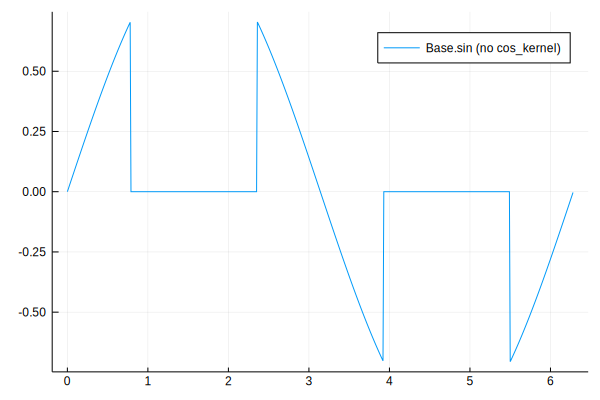

In [4]:
sin_kernel_base = baseFunction
sampleRange = 0.0f0:0.01f0:2.0f0pi          #vcat(collect(0.0f0:0.01f0:0.25f0*pi), collect(0.75f0*pi:0.01f0:1.25f0*pi), collect(1.75f0*pi:0.01f0:2.f0*pi));
plot(sampleRange, sintest.(sampleRange), label="Base.sin (no cos_kernel)")

We can see in this result that the section of `sin` which would use the `cos_kernel` function have been zero'd out to simplify the testing.

## Comparison Target

As we need a target to compare to, let's start by measuring the ULP distribution and accuracy of the sin function.

We start by collecting a sample of floats for the 32-bit implementation of sin and comparing it to the interval arithematic correctly-rounded result.

In [5]:
function GetULPTest(inputs, lowresResults)
    ULPRes = []
    for i in 1:length(inputs)
        dif   = abs(sin(BigFloat(inputs[i]))-BigFloat(lowresResults[i]))
        denom = BigFloat(eps(lowresResults[i]))
        r = dif/denom
        push!(ULPRes,Float32(r))
    end
    ULPRes
end

v = 0.1f0
sampleRange = []
while v < 0.25f0*pi
    push!(sampleRange, v)
    v = nextfloat(v)
end

v = 0.75f0*pi
while v < 1.25f0*pi
    push!(sampleRange, v)
    v = nextfloat(v)
end

v = 1.75f0*pi
while v < 2.f0*pi
    push!(sampleRange, v)
    v = nextfloat(v)
end

In [6]:
sin_kernel_base = baseFunction#
baseRes         = sintest.(sampleRange)
bigULPsrc       = GetULPTest(sampleRange, baseRes );

With the ULP results we can then take a sample of all ULP values and use it to plot a histogram of the distribution of all the errors. We can see from the results that the implementation of sin is good, with the majority of the results in the domain being correctly-rounded. Only a small number of results (approx ~0.01%) being 1 ULP.

This tells us that we have quite a large optimisation space to work in. As 1 ULP error is the limit, we could have every answer be exactly 1.0 ULP of error and it would not change the worse case or be unexpected behaviour.

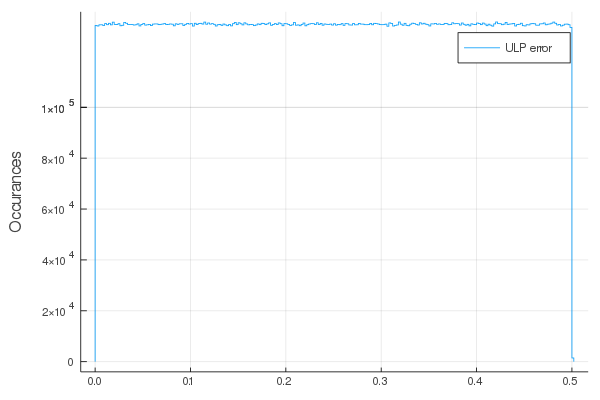

In [7]:
#sample(bigULPsrc, 1000000)
histogram(bigULPsrc, ylabel="Occurances", xlabel="",label="ULP error", fmt=:png)

## Analysing the `sin_kernel` function

As we not know there is some room to make this function less accurate without changing the expected behaviour we can now begin to analyse and exploit that space.

First we want to start by taking a copy of the expression tree to work with and use our tools to remove information that wont be helpful (e.g line number nodes), extract symbols for analysis and tag each expression in the tree.

In [8]:
fnCpy = deepcopy(modifiedKernel)
symb  = GetInputSymbols(fnCpy);
RemoveLineNumberNodes(fnCpy)
attachmentPoints,maxid = FindAttachmentPoints(fnCpy);

fnCpy now holds a simplified version of the expression tree and `attachmentPoints` holds a list of ID and expression pairs for the tree. Even for a small function like this there is a large number of points we could instrument to get details:

In [9]:
length(attachmentPoints)

61

As some of these attachment points represent large sections of the function, we can filter the list by the depth of each expression tree to find the smaller code we are more interested in. For example:

In [10]:
shortExpressions = FilterDepth(attachmentPoints,2,5);
println("Found $(length(shortExpressions)) expressions within the specified range")
for v in shortExpressions
    println(v)
end

Found 12 expressions within the specified range
(2, (2, :(sin_kernel(y::Float64))))
(2, (14, :(z = y * y)))
(2, (20, :(w = z * z)))
(2, (26, :(s = z * y)))
(2, (37, :(z * ex + -0.00019839334836096632)))
(2, (49, :(z * sresx + S1)))
(2, (60, :(y + s * sres)))
(3, (35, :(r = z * ex + -0.00019839334836096632)))
(3, (47, :(sres = z * sresx + S1)))
(3, (58, :((y + s * sres) + s * w * r)))
(4, (56, :(Float32((y + s * sres) + s * w * r))))
(5, (7, quote
    S1 = -0.16666666641626524
    S2 = 0.008333329385889463
    z = y * y
    w = z * z
    s = z * y
    ex = 2.718311493989822e-6
    r = z * ex + -0.00019839334836096632
    sresx = S2
    sres = z * sresx + S1
    Float32((y + s * sres) + s * w * r)
end))


This gives us a good idea of what our expression tree is looking like without having to dig through all possible points.
As it is all looking correct we have two options:

1) find interesting looking expressions and instrument those specifically

2) instrument all the local variables

As we are still exploring this function and instrumenting any specific instruction would be a guess, we can start with the local variables. Our tool allows simple code injection at any point. As this function is written in an almost Single Static Assigment way we can simply inject our local variable tracker at the end of the function. We can then run this function in our target range and we will be able to see the min and max value for all the values.

In [11]:
InsertTree(fnCpy, 56, :(TrackLocals(Base.@locals)));

If we now inspect the expression we will see our `TrackLocals` function above the last line of the function along with a reference to the line in our code in which we inserted it.

In [12]:
fnCpy

quote
    function sin_kernel(y::Float64)
        S1 = -0.16666666641626524
        S2 = 0.008333329385889463
        z = y * y
        w = z * z
        s = z * y
        ex = 2.718311493989822e-6
        r = z * ex + -0.00019839334836096632
        sresx = S2
        sres = z * sresx + S1
        begin
            TrackLocals(#= In[11]:1 =# Base.var"@locals"())
            Float32((y + s * sres) + s * w * r)
        end
    end
end

Now, we can run this function on a sample of data in our range and view the range of outputs for each variable

In [13]:
smallran = 0.0f0:0.001f0:pi/4.0f0
compiledChangedFunction = eval(fnCpy)
compiledChangedFunction.(smallran);
localsTrackingGlobal

Dict{Symbol,Any} with 10 entries:
  :w     => (0.0, 0.379733)
  :s     => (0.0, 0.483737)
  :S2    => (0.00833333, 0.00833333)
  :S1    => (-0.166667, -0.166667)
  :sresx => (0.00833333, 0.00833333)
  :y     => (0.0, 0.785)
  :z     => (0.0, 0.616225)
  :ex    => (2.71831e-6, 2.71831e-6)
  :r     => (-0.000198393, -0.000196718)
  :sres  => (-0.166667, -0.161531)

We see that the constants are static but many other variables have a large range. A large range means they can't be trivially replaced by a constant and we would need to do further analysis into how the function changes based on their value (see the next post on automatic differentiation).

However, a standout value is `r` which has very small range. This makes it a good candidate to test if it could be replaced with a constant.


## Testing an Approximation
So let's try that! We will take a fresh copy of the original function:

In [14]:
constantTestingFn = deepcopy(modifiedKernel);
symb              = GetInputSymbols(constantTestingFn);
RemoveLineNumberNodes(constantTestingFn);

Now we can simply insert a replacement assigment to `r` before it is used and we can see what that code looks like:

In [15]:
InsertTree(constantTestingFn, 56, :(r = -0.000196726))
constantTestingFn

quote
    function sin_kernel(y::Float64)
        S1 = -0.16666666641626524
        S2 = 0.008333329385889463
        z = y * y
        w = z * z
        s = z * y
        ex = 2.718311493989822e-6
        r = z * ex + -0.00019839334836096632
        sresx = S2
        sres = z * sresx + S1
        begin
            r = -0.000196726
            Float32((y + s * sres) + s * w * r)
        end
    end
end

And see that it still fits the curve:

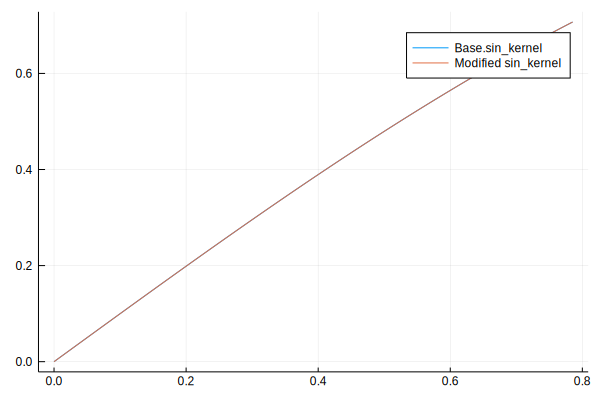

In [16]:
smallran = 0.0f0:0.0001f0:pi/4.0f0
constantImpl = eval(constantTestingFn)
plot(smallran, baseFunction.(smallran), label = "Base.sin_kernel")
plot!(smallran, constantImpl.(smallran), label = "Modified sin_kernel")

A quick check shows us that, for this value at least, the change hasn't resulted in error!

In [17]:
@show constantImpl(0.50f0)
@show baseFunction(0.50f0)

constantImpl(0.5f0) = 0.47942555f0
baseFunction(0.5f0) = 0.47942555f0


0.47942555f0

But, to test thoroughly we have to measure how far we have changed the function. This is done by seeing by how much we diverge from the base sin_kernel implementation.

In [18]:
iszero(x) = x != 0.0f0

constantImpl        = eval(constantTestingFn)
constantImplResults = constantImpl.(smallran) 
baseImplResults     = baseFunction.(smallran)


totalerrArr       = abs.(baseImplResults-constantImplResults)
incorrectResults  = filter( iszero ,totalerrArr)
uniqueErrorValues = unique(incorrectResults)
uniqueValuesCount = length(uniqueErrorValues)

totalerr   = sum(totalerrArr)
avgerr     = totalerr/length(baseImplResults)

println("Found $(length(incorrectResults)) incorrect of $(length(smallran)) samples")
println("\t consisting of $(uniqueValuesCount) unique error values:")
println("\t\t $(uniqueErrorValues)")
println("\t Total Error was: $(totalerr)")
println("\t Avg Error was: $(avgerr)")

Found 1125 incorrect of 7854 samples
	 consisting of 3 unique error values:
		 Float32[1.4901161e-8, 2.9802322e-8, 5.9604645e-8]
	 Total Error was: 5.90086e-5
	 Avg Error was: 7.513191e-9


This shows us that the difference was small but reasonably common. What happens when we use this new small error function within the `sin` function?

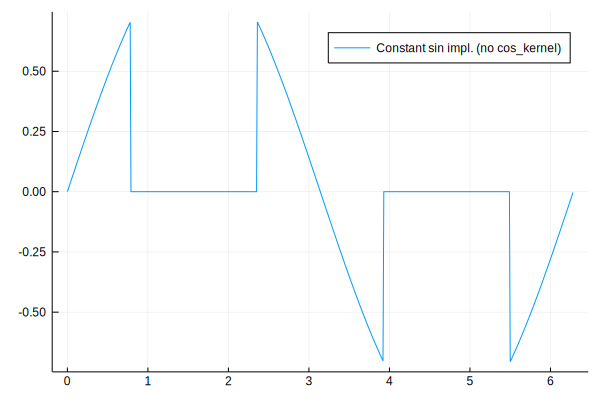

In [19]:
sin_kernel_base = constantImpl
sinrange = 0.0f0:0.01f0:2.0f0pi
plot(sinrange, sintest.(sinrange), label="Constant sin impl. (no cos_kernel)")

So far, so good. The `sin` function still produces a sin curve.
The important part now is to look at the details and see if we are still within the 1 ULP error limit.

In [20]:
sin_kernel_base = constantImpl
constRes        = sintest.(sampleRange)
bigULPconst     = GetULPTest(sampleRange, constRes );

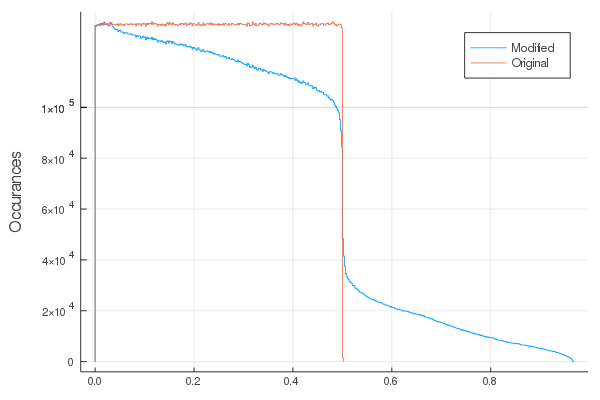

In [21]:
histogram(bigULPconst, ylabel="Occurances", xlabel="",label="Modified", fmt=:png)
histogram!(bigULPsrc, ylabel="Occurances", xlabel="",label="Original", fmt=:png)

In [22]:
println("Maximum ULP error in appropximation: $(maximum(bigULPconst))")
println("Maximum ULP error in base implementation: $(maximum(bigULPsrc))")

Maximum ULP error in appropximation: 0.9661933
Maximum ULP error in base implementation: 0.5000745


So here we can see where the error has resulted in some divergence from the original implementation - but not enough to cross the 1 ULP error threshold!
In summary, we have effectively identified this block of code:
```
ex = 2.718311493989822e-6
r  = z * ex + -0.00019839334836096632
```
and replaced it with a constant! This resulted in a loss of accuracy but did not exceed the acceptable error threshold already in place.

Success! Optimisation!

## Conclusion

So, why is this possible? These types of small wins to gain performance in mathematical code are quite common. Without the tools or time to investigate these little over-accuracies slip in.

This one in particular is the result of trying to minimise error by strictly following the algorithm to get the best result - and to its credit it does find a very good solution that is almost totally correctly-rounded. If the error-bound for this function was correct rounding then our implementation would be worse as we moved a lot of results further away from the correct answer and past the acceptable error bound.

To be able to take advantage of these types of optmisations we need to do four things:

    - To identify the real acceptable error-bound
    
    - Determine which transform can be applied to increase performance
    
    - Test the result robustly.
    
These are the three key problems when it comes to automating approximate computation: identifying where error is allowed, determine the correct transform and verify the result.
    

    